In [52]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import mplhep as hep
from jetnet.datasets import JetNet
from model.refinement import GNN, FCN
plt.style.use(hep.style.CMS)

In [53]:
model = GNN()
# model = FCN()
model.load_state_dict(torch.load('GNN_refinement.pt'))
# model.load_state_dict(torch.load('FCN_refinement.pt'))
model.cuda()

RuntimeError: Error(s) in loading state_dict for FCN:
	Missing key(s) in state_dict: "model.0.weight", "model.0.bias", "model.2.weight", "model.2.bias", "model.4.weight", "model.4.bias", "model.6.weight", "model.6.bias". 
	Unexpected key(s) in state_dict: "gcn.nn.0.weight", "gcn.nn.0.bias", "gcn.nn.2.weight", "gcn.nn.2.bias", "gcn.nn.4.weight", "gcn.nn.4.bias", "gcn.nn.6.weight", "gcn.nn.6.bias". 

In [32]:
np.random.seed(99)
def load_gluon_dataset(dataroot):
    particle_data, jet_data = JetNet.getData(jet_type=["g"], data_dir=dataroot)
    particle_data = particle_data[..., :-1] # toss mask dimension
    dataset_size = 1000
    np.random.shuffle(particle_data)
    particle_data = particle_data[:dataset_size]
    m = particle_data.mean(axis=1).reshape(-1, 1, 3)
    s = particle_data.std(axis=1).reshape(-1, 1, 3)
    return particle_data * s + m

In [33]:
samples = torch.load('/diffusionvol/experiments/test_generation/pvd_gluons/syn/samples.pth')
# ref = torch.load('/diffusionvol/experiments/test_generation/pvd_gluons/syn/ref.pth')
ref = load_gluon_dataset('/diffusionvol/data/')
samples = samples.numpy()
# ref = ref.numpy()

In [35]:
_samples = model(torch.tensor(samples).cuda())
_samples.shape

torch.Size([1000, 30, 3])

In [41]:
samples = _samples.detach().cpu().numpy()

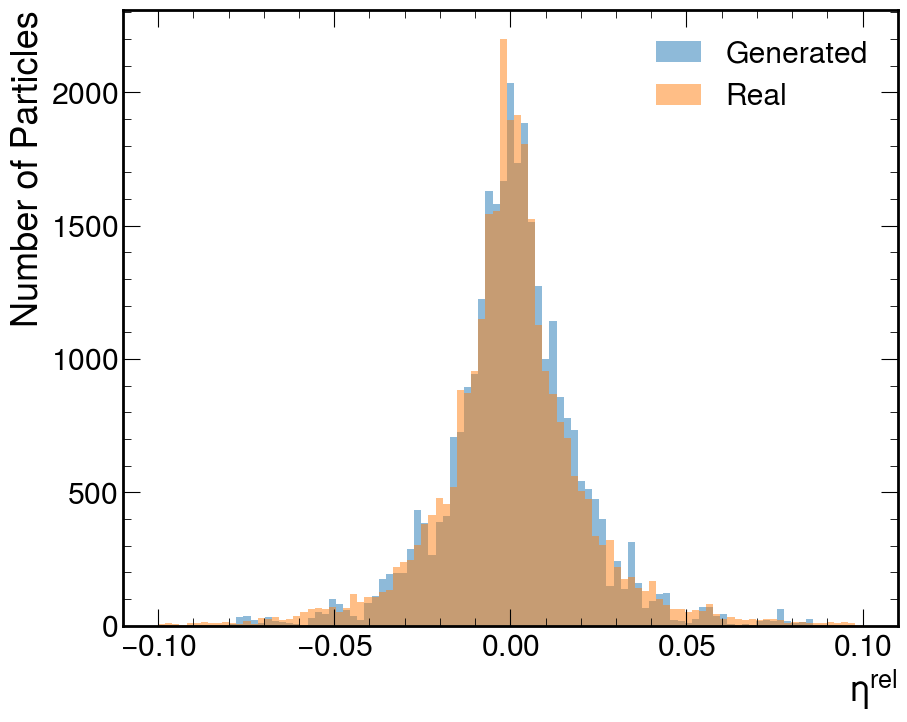

In [42]:
plt.figure(figsize=(10,8))
plt.hist(samples[..., 0].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 0].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$\eta^{rel}$")
plt.ylabel('Number of Particles')
plt.savefig('eta.png')
plt.show()

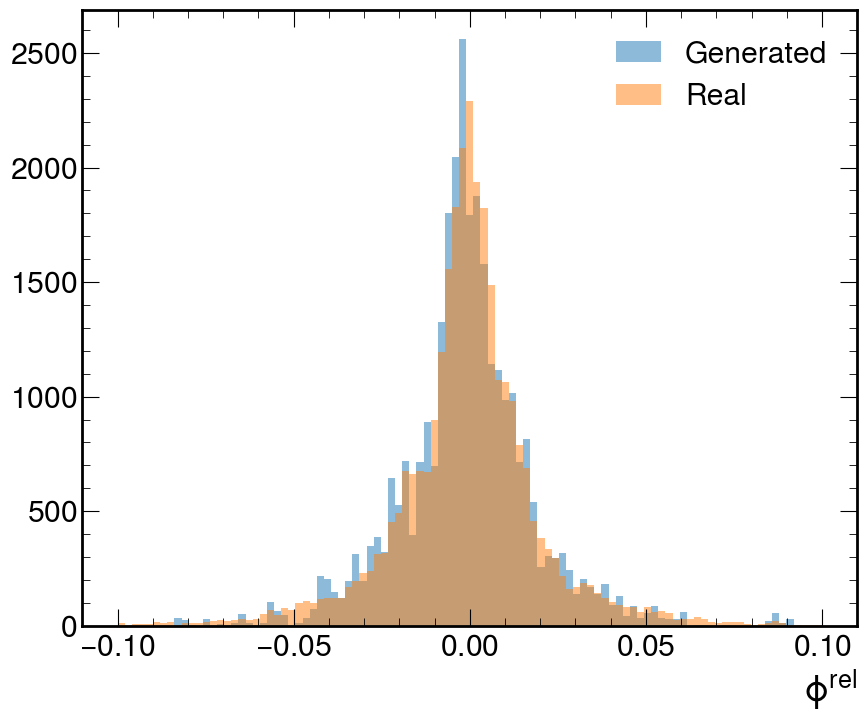

In [43]:
plt.style.use(hep.style.CMS)
plt.figure(figsize=(10,8))
plt.hist(samples[..., 1].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 1].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$\phi^{rel}$")
plt.savefig('phi.png')
plt.show()

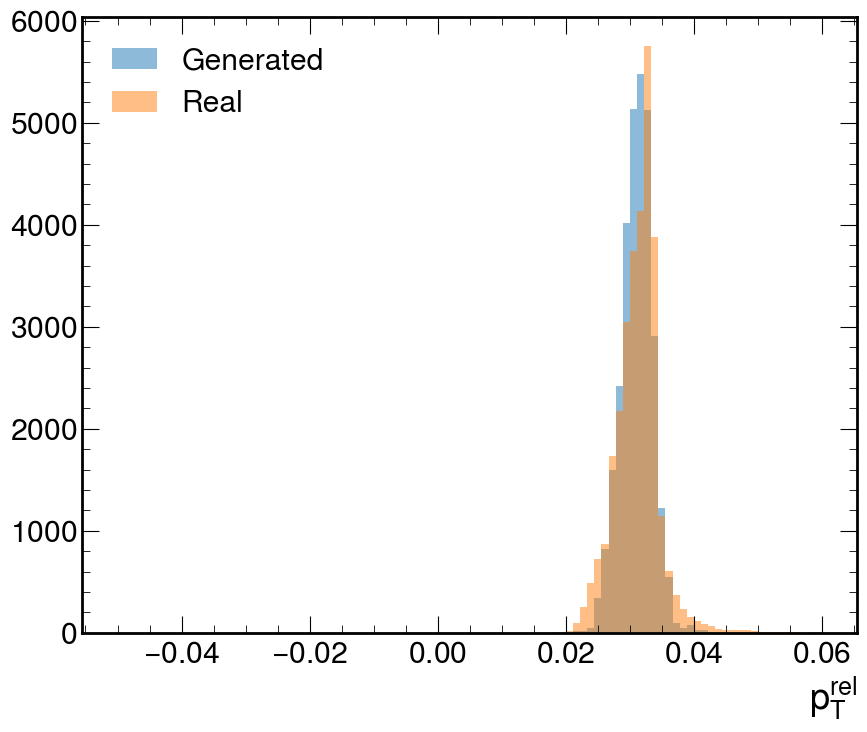

In [44]:
plt.style.use(hep.style.CMS)
plt.figure(figsize=(10,8))
plt.hist(samples[..., 2].flatten(), bins=np.linspace(-0.05, 0.06, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 2].flatten(), bins=np.linspace(-0.05, 0.06, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$p_T^{rel}$")
plt.savefig('pt.png')
plt.show()

In [45]:
from jetnet import evaluation

In [46]:
samples_pt_pos = samples
samples_pt_pos[..., -1] = samples_pt_pos[..., -1].clip(min=0)

In [47]:
cov, mmd = evaluation.cov_mmd(samples_pt_pos, ref)

Calculating cov and mmd over 10 batches: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


In [48]:
print(f'COV: {cov}')
print(f'MMD: {mmd}')

COV: 0.5060000000000001
MMD: 0.02024206386509177


In [49]:
w1efpm, w1efpstd = evaluation.w1efp(
    samples,
    ref,
    use_particle_masses=False,
    average_over_efps=True,
    return_std=True
)
print(w1efpm, w1efpstd)

1.277932660332757e-07 1.1858513495998086e-08


In [50]:
fpd = evaluation.fpnd(samples, jet_type='g')

/opt/conda/lib/python3.10/site-packages/jetnet/evaluation/gen_metrics.py:242: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(
Running ParticleNet: 100%|██████████| 63/63 [00:00<00:00, 171.50it/s]


In [51]:
fpd

129.63397556982648